## Importy

In [609]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Funkcje pomocnicze

In [610]:
def make_signal(f, pulsation, ampl=1):
    return (lambda t: ampl* f(pulsation * t)), 2 * np.pi / pulsation


def sample_signal(signal, period, num_samples):
    delta_t = period / num_samples
    dirac_d = np.arange(0, period, delta_t)
    return signal(dirac_d), dirac_d



# Zad 1

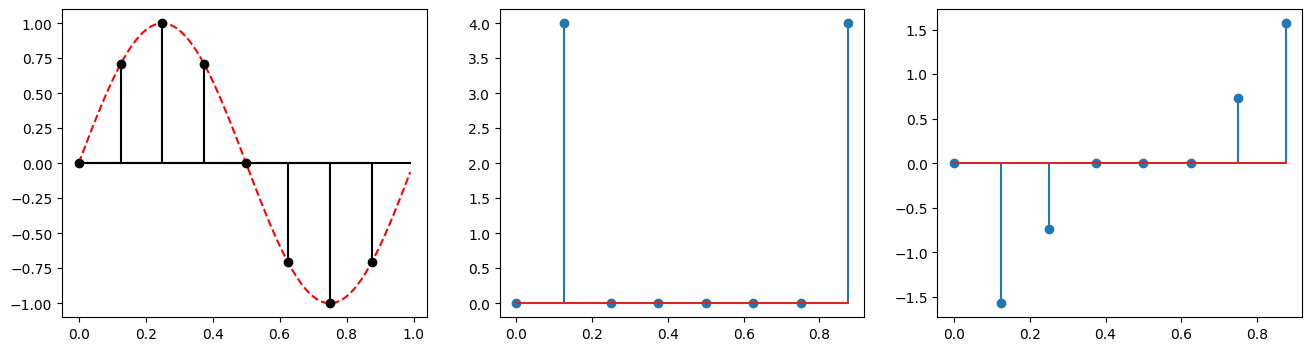

In [611]:
sin, period = make_signal(np.sin, 2 * np.pi)
samples, dirac_d = sample_signal(sin, period, 8)
spectrum_sin = np.fft.fft(samples)
freq_spectrum_sin = np.abs(spectrum_sin)
phase_spectrum_sin = np.angle(spectrum_sin)

X_cont = np.arange(0, period, 0.01)
X_discr = dirac_d

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(X_cont, sin(X_cont), "--", color="red")
ax[0].stem(X_discr, samples, linefmt='k-', markerfmt='o', basefmt='k-')
ax[0].plot(X_cont, np.zeros(X_cont.shape), color="black")  # line

ax[1].stem(X_discr, freq_spectrum_sin)

ax[2].stem(X_discr, phase_spectrum_sin)

plt.show()

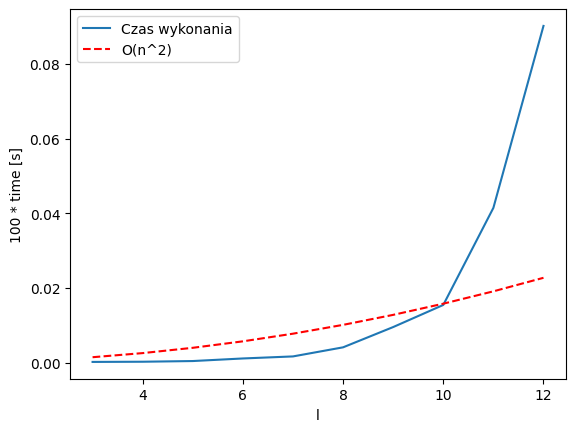

In [612]:
tested_n = range(3, 12+1)
results = []
for n in tested_n:
    samples, dirac_d = sample_signal(sin, period, 1000*2**n)
    start = timer()
    np.fft.fft(samples)
    results.append(timer() - start)
    

fig, ax = plt.subplots()

ax.plot(tested_n, results)
ax.set_xlabel("l")
ax.set_ylabel("100 * time [s]")
comp = [results[0] * n**2 for n in tested_n]
ax.plot(tested_n, comp, "--", color="red")

plt.legend(["Czas wykonania", "O(n^2)"])


plt.show()


    

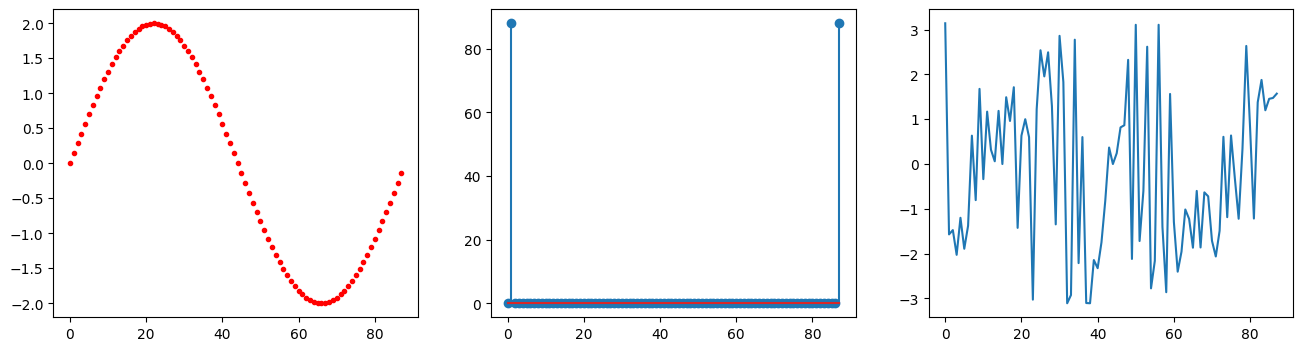

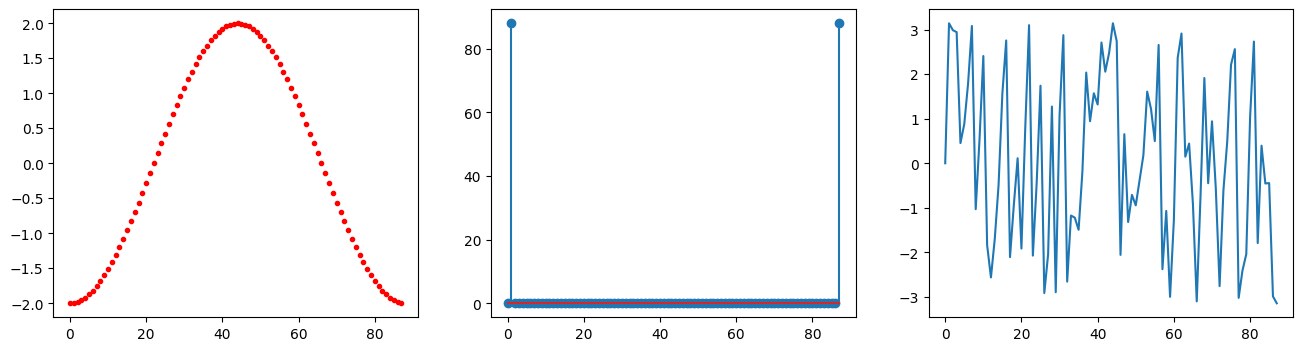

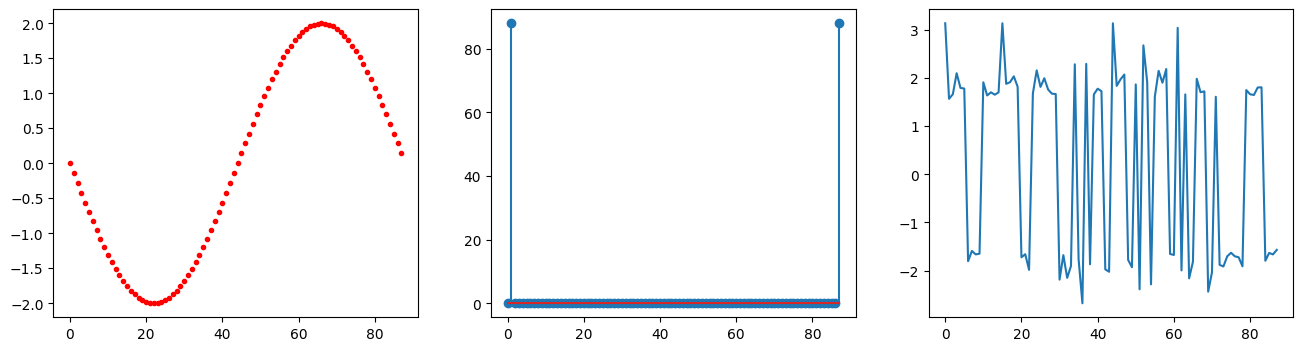

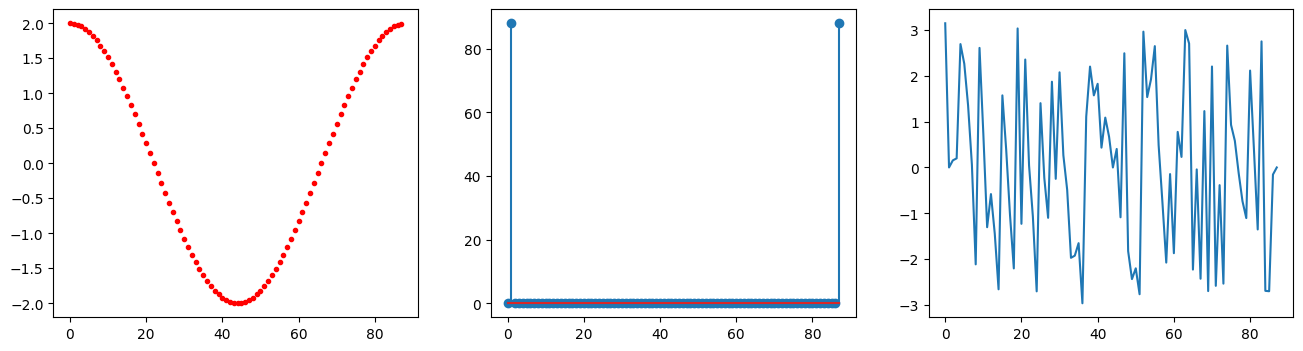

In [613]:
N = 88
A = 2
shifts = [0, N/4, N/2, 3*N/4]

for shift in shifts:
    sin, period = make_signal(np.sin, 2 * np.pi / N, A)
    
    shifted_sin = lambda n: sin(n - shift)
    
    samples, _ = sample_signal(shifted_sin, period, N)
    
    spectrum_sin = np.fft.fft(samples)
    freq_spectrum_sin = np.abs(spectrum_sin)
    phase_spectrum_sin = np.angle(spectrum_sin)
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    ax[0].plot(samples, ".", color="red")
    ax[1].stem(freq_spectrum_sin)
    ax[2].plot(phase_spectrum_sin)



